## Final Exam - DS412 Time Series Analysis and Stochastic Methods

Name: Chris Andrei Irag <br>
Section: DS4A

### Part 1. Essay (Situational/Applied) Questions|

**Q1.** Differentiate and elaborate ARIMA from SARIMA and vice versa. You can use illustrations and mathematical expression should you want to.

SARIMA is simply an innovation of ARIMA, incorporating the seasonal variations of each component in ARIMA: (1) Seasonal Autoregressive, Seasonal Differencing, Seasonal Moving Average.

**Q2.** Given that we have undergone a couple of metrics in calculating error for TSA, choose 3 among all those metrics and elaborate. 

Mean Squared Error - Evaluates the errors and uses the square function to remove the negative numbers and convert them to squared distances. This metric focuses on the squared distances and not differences.

RMSE - The same metric as MSE, however it is squared to maintain explainability making the results in the same units as the exogenous variable.

MASE - The same metric as Mean Squared Error, but only looks at seasonal errors. Seasonal errors are computed using distances from the current season to the previous season at their respective period in time.

**Q3.** Given the implementation of baseline predictions below, kindly differentiate **mean forecasts** from **naive forecasts**.

<code>def meanf(ts, h):
    f = np.mean(ts)
    f = np.repeat(f, repeats=h)
    return f
</code>
    
<code>def naivef(ts, h):
    f = ts[-1]
    f = np.repeat(f, repeats=h)
    return f 
</code>

Mean forecasts: Simply forecast the next observation by always using the mean, regardless of any inputs. Your heuristic is 'it will always return to the average'.

Naive forecasts: Simple forecast the next observation by always using the last observation, regardless of any inputs. The heuristic is simply 'do not change the status quo`, often fit only for 1 horizon period forecast.

**Q4.** Based on your understanding, explain the **LightGBM** algorithm in tiime series forecasting. 

Light GBM uses a tree-based approach to forecast. As well as use multiple $N$ estimators trained on random permutations of the data, such that each output of each estimator is practically a vote, this architecture takes advantage of 'wisdom of the crowd' or 'normally distributed consensus'. Being a 'gradient' based algorithm, it also learns or improves its parameters using 'Gradient Descent'.

**Q5.** In machine learning time series forecasting, why do we need to divide the dataset into train and test? 

We divide the dataset into train and test, so that we have the opportunity to evaluate the model (trained on the train set) on unseen data (test set). Evaluating the model on unseen data informs us that the model will perform relatively the same to the test set when new data comes in.

### Part 2. Time Series Forecasting (Code Implementation) 

Instructions: Document and explain your code as you go along the items. The better documentation, the higher the points. 

**Problem 1.** Predicting Google's Stock Price using ARIMA

Document your code properly and satisfy the following conditions:

1. Create an ARIMA model in predicting the **Quarterly Google Stock Price** from the `goog200.csv` dataset provided in this same repository. 
2. Assume that the dataset is of quarterly intervals
3. Just use the **most recent** 20 years of data (i.e 80 quarters or datapoints). 
4. Visualize the dataset.
5. Find the optimal ARIMA model from the following set of p, d, q values: 
> p: from 0 to 5 <br>
> d: d = 1 <br>
> q: from 0 to 5

6. Predict the next 2 years of data (8 quarters). Plot the predictions together with the historical data
7. Evaluate the performance of the model using RMSE. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from iragca.matplotlib import Styles

plt.style.use(Styles.ML.value)

# Create a pseudo quarterly date range for the data
pseudo_date_range = pd.date_range(start="2010-01-01", periods=200, freq="QE")

# Load and preprocess the data
data = ( 
    pd.read_csv("goog200.csv")                          # Load the CSV file
    .drop("index", axis=1)                              # Drop the 'index' column            
    .assign(Date=pseudo_date_range)                     # Assign the pseudo date range   
    .rename(columns={"value": "Google Stock Price"})    # Rename the 'value' column
)
data

,Google Stock Price,Date
0,392.830017,2010-03-31
1,392.512085,2010-06-30
2,397.305908,2010-09-30
3,398.011322,2010-12-31
4,400.490204,2011-03-31
...,...,...
195,523.832947,2058-12-31
196,523.226929,2059-03-31
197,525.671021,2059-06-30
198,525.253723,2059-09-30


Our data's temporal resolution is quarterly.

Text(0, 1, 'Google Stock Price')

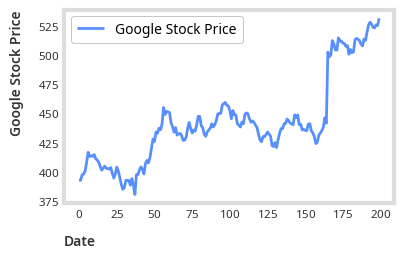

In [2]:
# Display the entire dataset
sns.lineplot(data)
plt.xlabel("Date")
plt.ylabel("Google Stock Price")

Text(0, 1, 'Google Stock Price')

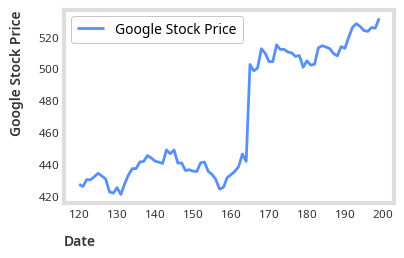

In [3]:
# Separate and display the most recent 80 entries of the dataset as per requirement
df = data[-80:].copy()
sns.lineplot(df)
plt.xlabel("Date")
plt.ylabel("Google Stock Price")

In [4]:
# Train and Test Split
TEST_SIZE = 8 # 8 quarters = 2 years
train = df[:-TEST_SIZE]
test = df[-TEST_SIZE:]

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from typing import Tuple, Iterable, Optional
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")


# Define types for clarity
type pdq = Tuple[Iterable[int], Iterable[int], Iterable[int]]
type PDQs = Tuple[Iterable[int], Iterable[int], Iterable[int], int]


# Build a SARIMA Optimizer class
class SARIMAOptimizer:

    def __init__(self, pdq: pdq, PDQs: Optional[PDQs] = None):
        self.p, self.d, self.q = pdq

        if PDQs is not None:
            self.P, self.D, self.Q, self.s = PDQs
        else:
            self.P, self.D, self.Q, self.s = (0,), (0,), (0,), 0

    @property
    def combinations(self) -> Iterable[Tuple[int, int, int, int, int, int, int]]:
        """Generate all combinations of pdq and PDQs parameters."""
        return list(product(
            self.p, self.d, self.q, self.P, self.D, self.Q, [self.s]
        ))
    
    def fit(self, train_data: pd.DataFrame) -> SARIMAX:
        """Fit the SARIMA model with the given parameters."""
        best_aic = float("inf")
        best_model = None

        # Iterate through all parameter combinations
        # and fit the SARIMA model
        pbar = tqdm(self.combinations, desc="SARIMA Optimization")
        # We use set_postfix to display AIC values in the progress bar live
        pbar.set_postfix({"AIC": None, "Best AIC": None})
        for (p, d, q, P, D, Q, s) in pbar:
                # We use a try-except block to handle any fi◘tting errors gracefully
                try:
                    model = SARIMAX(
                        train_data,
                        order=(p, d, q),
                        seasonal_order=(P, D, Q, s),
                    )
                    results = model.fit(disp=False)
                except Exception:
                    continue

                aic = results.aic
                pbar.set_postfix({"AIC": aic, "Best AIC": best_aic})

                # Update best model if current AIC is lower
                if aic < best_aic:
                    pbar.set_postfix({"AIC": aic, "Best AIC": best_aic})
                    best_aic = results.aic
                    best_model = results

        # Return the best model found
        return best_model

In [6]:
# Optimize SARIMA parameters and fit the model
optimizer = SARIMAOptimizer(
    pdq=(range(0, 5), range(1, 2), range(0, 5)),
    PDQs=None
)
best_arima_model = optimizer.fit(train["Google Stock Price"])

SARIMA Optimization: 100%|██████████| 25/25 [00:01<00:00, 17.06it/s, AIC=514, Best AIC=506]


<Axes: xlabel='Date', ylabel='Google Stock Price'>

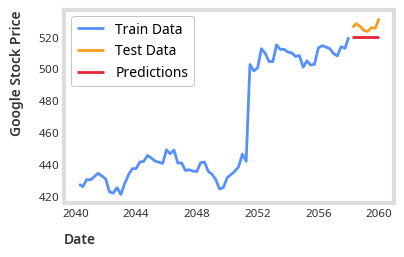

In [7]:
# Generate predictions
pred = best_arima_model.get_forecast(steps=TEST_SIZE).predicted_mean

# Create a date range for the prediction period
prediction_date_range = pd.date_range(
    start=train["Date"].max() + pd.DateOffset(months=3),
    periods=TEST_SIZE,
    freq="QE"
)

# Plot the results with predictions☻
sns.lineplot(data=train, x="Date", y="Google Stock Price", label="Train Data")
sns.lineplot(data=test, x="Date", y="Google Stock Price", label="Test Data")
sns.lineplot(x=prediction_date_range, y=pred, label="Predictions")

In [8]:
from sklearn.metrics import root_mean_squared_error

# Calculate and display RMSE
rmse = root_mean_squared_error(test["Google Stock Price"], pred)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Root Mean Squared Error (RMSE): 7.06


Evaluation: An RMSE of 7.06 indicates that, on average, the predicted Google Stock Prices deviate from the actual prices by approximately $7.06.
Without another model to compare to, we can not relatively evaluate this model with respect to other existing models.

**Problem 2.** Predicting Google's Stock Price using SARIMA

Document your code properly and satisfy the following conditions:

1. Create an ARIMA model in predicting the **Quarterly Google Stock Price** from the `goog200.csv` dataset provided in this same repository. 
2. Assume that the dataset is of quarterly intervals
3. Just use the **most recent** 20 years of data (i.e 80 quarters or datapoints). 
4. Visualize the dataset.
5. Find the optimal ARIMA model from the following set of p, d, q values: 

> p: from 0 to 5; P: from 0 to 5 

> d: d = 1; D: D = 1

> q: from 0 to 5; Q: from 0 to 5 

6. Predict the next 2 years of data (8 quarters). Plot the predictions together with the historical data
7. Evaluate the performance of the model using RMSE. 

<Axes: xlabel='Date', ylabel='Google Stock Price'>

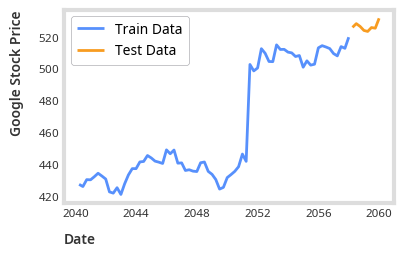

In [9]:
# We use the same train and test splits and recent 80 entries of the dataset
# We display the train and test splits
sns.lineplot(data=train, x="Date", y="Google Stock Price", label="Train Data")
sns.lineplot(data=test, x="Date", y="Google Stock Price", label="Test Data")

In [10]:
# Optimize SARIMA parameters with seasonality and fit the model
optimizer = SARIMAOptimizer(
    pdq=(range(0, 5), range(1, 2), range(0, 5)),
    PDQs=(range(0, 5), range(1, 2), range(0, 5), 4)
)
best_sarima_model = optimizer.fit(train["Google Stock Price"])

SARIMA Optimization: 100%|██████████| 625/625 [06:37<00:00,  1.57it/s, AIC=501, Best AIC=491]


<Axes: xlabel='Date', ylabel='Google Stock Price'>

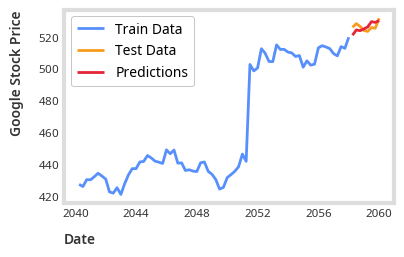

In [11]:
# Generate predictions
pred = best_sarima_model.get_forecast(steps=TEST_SIZE).predicted_mean

# Create a date range for the prediction period
prediction_date_range = pd.date_range(
    start=train["Date"].max() + pd.DateOffset(months=3),
    periods=TEST_SIZE,
    freq="QE"
)

# Plot the results with predictions
sns.lineplot(data=train, x="Date", y="Google Stock Price", label="Train Data")
sns.lineplot(data=test, x="Date", y="Google Stock Price", label="Test Data")
sns.lineplot(x=prediction_date_range, y=pred, label="Predictions")

In [12]:
# Calculate and display RMSE
rmse = root_mean_squared_error(test["Google Stock Price"], pred)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Root Mean Squared Error (RMSE): 3.27


Evaluation: With an RMSE of 3.27, this SARIMA model is superior to the previous ARIMA model that had an RMSE score 7.06. We reduce our average prediction errors by $3.79.

**Problem 3.** Predicting Debit Card transactions using Exponential Smoothing

1. Use the provided data named `debitcards.csv`. <br> <br>
2. Visualize the data with proper axis labels and title. Interpret the visualization in 2-3 sentences. <br> <br>
3. Perform Simple Exponential Smoothing (SES) using the optimized SES parameters on the train data through `optimized=True`. The test size is equal to 4 months. Compare SES predictions with predictons from `Mean Method`, `naive Method`, and `Drift`. Plot predictions with the true data. Evaluate the predictions using `MAE`, `RMSE`, and `MAPE` in a DataFrame. Interpret the resulting DataFrame. <br> <br>
4. Perform Seasonality Methods forecasting on the train data using Holt-Winters Additive Version and Holt-Winters Multiplicative Version. Identify the seasonal component of the dataset first and limit `max_iter=100` for convergence. The test size is equal to 24 months. Compare `Holt-Winters ADD` and `Holt-Winters MUL` predictions with predictons from `Seasonal Naive` and `Naive`. Plot predictions with the true data. Evaluate the predictions using `MASE_SEA`, `RMSE`, and `MAPE` in a DataFrame. Interpret the resulting DataFrame. 

In [13]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing

# Load and preprocess the debit cards dataset
debit_cards_data = (
    pd.read_csv("debitcards.csv")
    .rename(columns={"index": "Date", "value": "Debit Card Transactions"})
)

debit_cards_df = (
  debit_cards_data
  .assign(Date=pd.to_datetime(debit_cards_data["Date"])) # Ensure 'Date' is in datetime format
)

debit_cards_df

,Date,Debit Card Transactions
0,2000-01-01,7.204
1,2000-02-01,7.335
2,2000-03-01,7.812
3,2000-04-01,7.413
4,2000-05-01,9.136
...,...,...
159,2013-04-01,21.573
160,2013-05-01,23.685
161,2013-06-01,22.104
162,2013-07-01,25.340


Our data seem to be monthly

Text(0.5, 1.0, 'Debit Card Transactions Over Time')

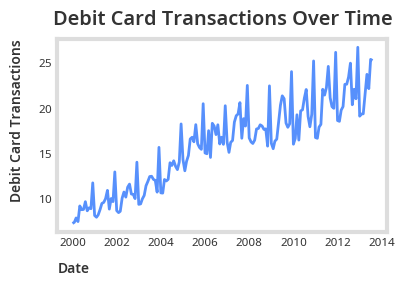

In [14]:
sns.lineplot(data=debit_cards_df, x="Date", y="Debit Card Transactions")
plt.title("Debit Card Transactions Over Time")

The data seen right away displays trend, and seasonality. The data seem to encompass a large time, 2000-2014. The variance over time seems to increase particularly right after year 2008 and beyond.

In [15]:
# We split the debit cards dataset into train and test sets
# Using 4 months for the test set as required
TEST_SIZE = 4 # 4 months

train = debit_cards_df[:-TEST_SIZE]
test = debit_cards_df[-TEST_SIZE:]

In [64]:
# We specify simpler models for us to use as benchmarks
class SimpleModels:

    @staticmethod
    def naive_forecast(train_data: pd.Series, steps: int) -> pd.Series:
        """Naive Forecasting: Use the last observed value for all future predictions."""
        last_value = train_data.iloc[-1]
        return pd.Series([last_value] * steps)

    @staticmethod
    def mean_forecast(train_data: pd.Series, steps: int) -> pd.Series:
        """Mean Forecasting: Use the mean of the training data for all future predictions."""
        mean_value = train_data.mean()
        return pd.Series([mean_value] * steps)

    @staticmethod
    def drift_forecast(train_data: pd.Series, steps: int) -> pd.Series:
        """Drift Forecasting: Use the trend from the first to the last observation."""
        n = len(train_data)
        drift = (train_data.iloc[-1] - train_data.iloc[0]) / (n - 1)
        return pd.Series([train_data.iloc[-1] + drift * (i + 1) for i in range(steps)])
    
    @staticmethod
    def seasonal_naive_forecast(train_data: pd.Series, steps: int, seasonal_periods: int) -> pd.Series:
        """Seasonal Naive Forecasting: Use the last observed value from the same season."""
        seasonal_values = train_data[-seasonal_periods:]
        repetitions = (steps // seasonal_periods) + 1
        forecast = (seasonal_values.tolist() * repetitions)[:steps]
        return pd.Series(forecast)

In [17]:
ses_model = SimpleExpSmoothing(train["Debit Card Transactions"]).fit(optimized=True)

<Axes: xlabel='Date', ylabel='Debit Card Transactions'>

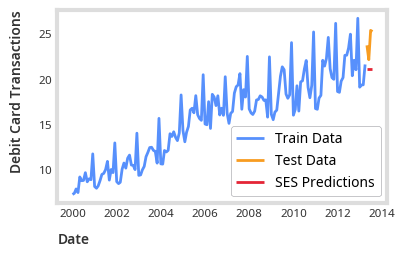

In [18]:
ses_pred = ses_model.forecast(steps=TEST_SIZE)

sns.lineplot(data=train, x="Date", y="Debit Card Transactions", label="Train Data")
sns.lineplot(data=test, x="Date", y="Debit Card Transactions", label="Test Data")
sns.lineplot(x=test["Date"], y=ses_pred, label="SES Predictions")

Text(0.5, 1.0, 'Debit Card Transactions Forecasting Comparison')

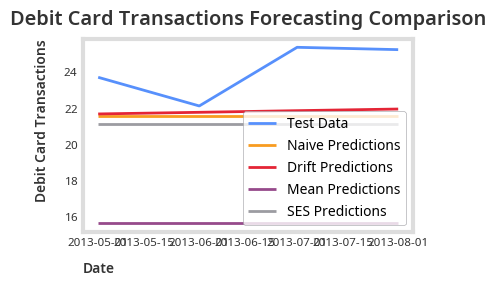

In [32]:
naive_pred = SimpleModels.naive_forecast(train["Debit Card Transactions"], TEST_SIZE)
drift_pred = SimpleModels.drift_forecast(train["Debit Card Transactions"], TEST_SIZE)
mean_pred = SimpleModels.mean_forecast(train["Debit Card Transactions"], TEST_SIZE)

sns.lineplot(data=test, x="Date", y="Debit Card Transactions", label="Test Data")
sns.lineplot(x=test["Date"], y=naive_pred.to_list(), label="Naive Predictions")
sns.lineplot(x=test["Date"], y=drift_pred.to_list(), label="Drift Predictions")
sns.lineplot(x=test["Date"], y=mean_pred.to_list(), label="Mean Predictions")
sns.lineplot(x=test["Date"], y=ses_pred, label="SES Predictions")
plt.title("Debit Card Transactions Forecasting Comparison")

We can see that the Naive and Drift, Naive and SES predictions follow the test data closer than mean predictions.

Text(0.07, 0.5, 'Models')

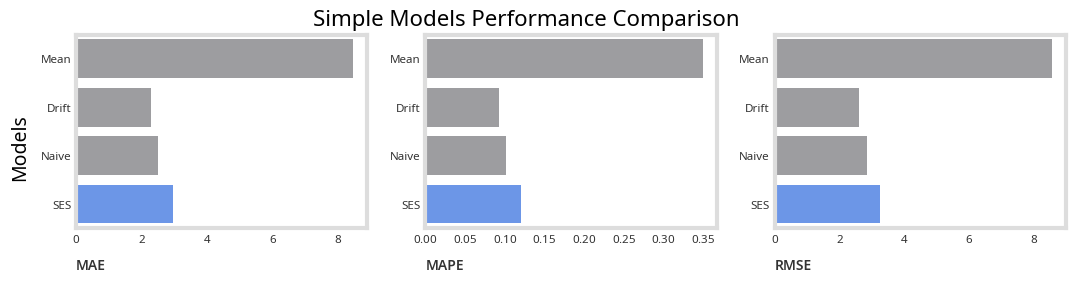

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from iragca.matplotlib import Color


## Evaluate Simple Models
## Compare their performance using MAE, MAPE, and RMSE by plot and table
simple_models = {
    "Mean": SimpleModels.mean_forecast,
    "Drift": SimpleModels.drift_forecast,
    "Naive": SimpleModels.naive_forecast,
}

results_df = pd.DataFrame(columns=["Model", "MAE", "MAPE", "RMSE"])


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 2.5))

# Iteratively evaluate each simple model and then plot the results
for model_name, model_func in simple_models.items():
    simple_pred = model_func(train["Debit Card Transactions"], steps=TEST_SIZE)
    mae = mean_absolute_error(test["Debit Card Transactions"], simple_pred)
    mape = mean_absolute_percentage_error(test["Debit Card Transactions"], simple_pred)
    rmse = root_mean_squared_error(test["Debit Card Transactions"], simple_pred)

    results_df = pd.concat([
        results_df,
        pd.DataFrame({
            "Model": [model_name],
            "MAE": [mae],
            "MAPE": [mape],
            "RMSE": [rmse],
        })
    ], ignore_index=True)

    sns.barplot(y=[model_name], x=[mae], ax=ax1, orient="h", color=Color.GRAY.value)
    sns.barplot(y=[model_name], x=[mape], ax=ax2, orient="h", color=Color.GRAY.value)
    sns.barplot(y=[model_name], x=[rmse], ax=ax3, orient="h", color=Color.GRAY.value)

    ax1.set_xlabel("MAE")
    ax2.set_xlabel("MAPE")
    ax3.set_xlabel("RMSE")


# Compute and plot SES results as well
ses_mae = mean_absolute_error(test["Debit Card Transactions"], ses_pred)
ses_mape = mean_absolute_percentage_error(test["Debit Card Transactions"], ses_pred)
ses_rmse = root_mean_squared_error(test["Debit Card Transactions"], ses_pred)

results_df = pd.concat([
    results_df,
    pd.DataFrame({
        "Model": ["SES"],
        "MAE": [ses_mae],
        "MAPE": [ses_mape],
        "RMSE": [ses_rmse],
    })
], ignore_index=True)

sns.barplot(y=["SES"], x=[ses_mae], ax=ax1, orient="h")
sns.barplot(y=["SES"], x=[ses_mape], ax=ax2, orient="h")
sns.barplot(y=["SES"], x=[ses_rmse], ax=ax3, orient="h")
fig.suptitle("Simple Models Performance Comparison", y=1.05, fontsize=16)
fig.supylabel("Models", fontsize=14, x=0.07)

In [20]:
results_df

,Model,MAE,MAPE,RMSE
0,Mean,8.463225,0.349392,8.564928
1,Drift,2.286072,0.092281,2.606072
2,Naive,2.512000,0.101538,2.835835
3,SES,2.959441,0.120173,3.238844


The results show that SES comes 3rd in performance, followed by Mean forecasting, which has 3x the erros than the rest of the models. Drift forecasting seems to be the better model in this particular case.

### Holt-Winters Additive

In [33]:
TEST_SIZE = 24 # 24 months = 2 years

train = debit_cards_df[:-TEST_SIZE]
test = debit_cards_df[-TEST_SIZE:]

In [ ]:
SEASONAL_PERIODS = 12 # Monthly data with yearly seasonality


# Compute predctions for all models
model_add = ExponentialSmoothing(
    train["Debit Card Transactions"], 
    trend="add", 
    seasonal="add", 
    seasonal_periods=SEASONAL_PERIODS
).fit(smoothing_level=0.8)
pred_add = model_add.forecast(steps=TEST_SIZE)

model_mul = ExponentialSmoothing(
    train["Debit Card Transactions"], 
    trend="mul", 
    seasonal="mul", 
    seasonal_periods=SEASONAL_PERIODS,
).fit(smoothing_level=0.8)
pred_mul = model_mul.forecast(steps=TEST_SIZE)

prediction_date_range = pd.date_range(
    start=train["Date"].max(),
    end=train["Date"].max() + pd.DateOffset(months=TEST_SIZE),
    freq='M'
)

seasonal_naive_pred = SimpleModels.seasonal_naive_forecast(
    train["Debit Card Transactions"], 
    steps=TEST_SIZE, 
    seasonal_periods=SEASONAL_PERIODS
)

naive_pred = SimpleModels.naive_forecast(
    train["Debit Card Transactions"], 
    steps=TEST_SIZE
)

<Axes: xlabel='None', ylabel='None'>

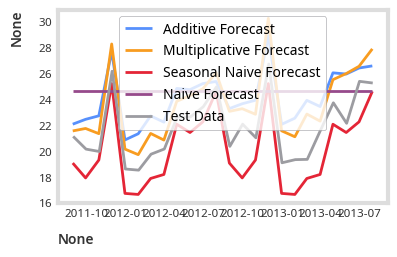

In [ ]:
# Plot the results with predictions
prediction_date_range = pd.date_range(
    start=train["Date"].max(),
    end=train["Date"].max() + pd.DateOffset(months=TEST_SIZE),
    freq='M'
)

sns.lineplot(x=prediction_date_range, y=pred_add, label="Additive Forecast")
sns.lineplot(x=prediction_date_range, y=pred_mul, label="Multiplicative Forecast")
sns.lineplot(x=prediction_date_range, y=seasonal_naive_pred, label="Seasonal Naive Forecast")
sns.lineplot(x=prediction_date_range, y=naive_pred, label="Naive Forecast")
sns.lineplot(data=test, x="Date", y="Debit Card Transactions", label="Test Data")

They all seem to follow the test data closely with varying degrees of errors, the opposite case for the Naive forecast.

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

def mase_sea(y_true, y_pred, time_series, season_length: int):
    """Mean Absolute Scaled Error with seasonality"""
    return np.mean(np.abs((y_true - y_pred)/np.mean(np.abs(time_series[season_length:] - time_series[:-season_length]))))

# Evaluate all models
mase_sea_add = mase_sea(test["Debit Card Transactions"].to_numpy(), pred_add, train["Debit Card Transactions"].to_numpy(), SEASONAL_PERIODS)
mase_sea_mul = mase_sea(test["Debit Card Transactions"].to_numpy(), pred_mul, train["Debit Card Transactions"].to_numpy(), SEASONAL_PERIODS)
mase_sea_snaive = mase_sea(test["Debit Card Transactions"].to_numpy(), seasonal_naive_pred.to_numpy(), train["Debit Card Transactions"].to_numpy(), SEASONAL_PERIODS)
mase_sea_naive = mase_sea(test["Debit Card Transactions"].to_numpy(), naive_pred.to_numpy(), train["Debit Card Transactions"].to_numpy(), SEASONAL_PERIODS)
mape_add = mean_absolute_percentage_error(test["Debit Card Transactions"], pred_add)
mape_mul = mean_absolute_percentage_error(test["Debit Card Transactions"], pred_mul)
mape_snaive = mean_absolute_percentage_error(test["Debit Card Transactions"], seasonal_naive_pred)
mape_naive = mean_absolute_percentage_error(test["Debit Card Transactions"], naive_pred)
rmse_snaive = root_mean_squared_error(test["Debit Card Transactions"], seasonal_naive_pred)
rmse_naive = root_mean_squared_error(test["Debit Card Transactions"], naive_pred)
rmse_add = root_mean_squared_error(test["Debit Card Transactions"], pred_add)
rmse_mul = root_mean_squared_error(test["Debit Card Transactions"], pred_mul)

# Compile results into a DataFrame
results_df = pd.DataFrame({
    "Model": ["Additive", "Multiplicative", "Seasonal Naive", "Naive"],
    "MASE_Sea": [mase_sea_add, mase_sea_mul, mase_sea_snaive, mase_sea_naive],
    "MAPE": [mape_add, mape_mul, mape_snaive, mape_naive],
    "RMSE": [rmse_add, rmse_mul, rmse_snaive, rmse_naive],
})
results_df

,Model,MASE_Sea,MAPE,RMSE
0,Additive,1.748692,0.108441,2.452854
1,Multiplicative,1.372979,0.082487,1.996117
2,Seasonal Naive,1.326136,0.081301,1.959670
3,Naive,2.468362,0.157639,3.678942


Text(0.5, 1.0, 'RMSE Comparison')

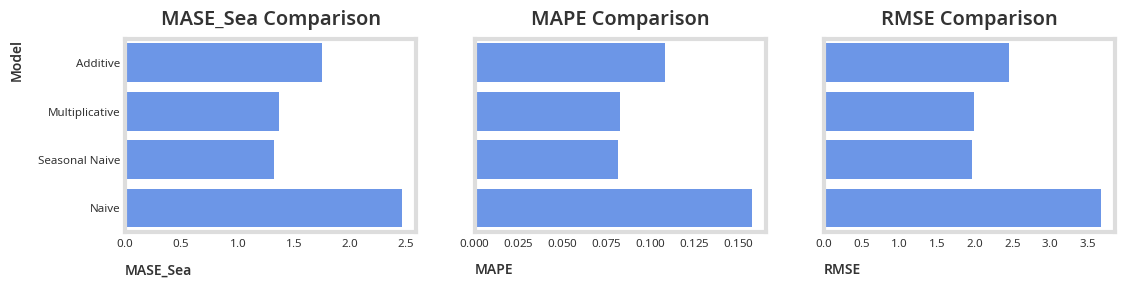

In [ ]:
# Plot the comparison results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 2.5), sharey=True)
sns.barplot(data=results_df, x="MASE_Sea", y="Model", orient="h", ax=ax1)
sns.barplot(data=results_df, x="MAPE", y="Model", orient="h", ax=ax2)
sns.barplot(data=results_df, x="RMSE", y="Model", orient="h", ax=ax3)


ax1.set_xlabel("MASE_Sea")
ax2.set_xlabel("MAPE")
ax3.set_xlabel("RMSE")
ax1.set_title("MASE_Sea Comparison")
ax2.set_title("MAPE Comparison")
ax3.set_title("RMSE Comparison")

We can see Naive forecast has the greatest errors, seasonal naive, and multiplicative holt-winters seem to perform on par with each other, Seasonal Naive just slighy better. The additive holt-winters model comes in 3rd place.